# Classification using Logistic Regression
In this notebook, we revisit the classification problem using logistic regression.

**Learning Objectives**

By the end of this notebook, you should be able to 
1. Explain the formulation of logistic regression and how it is used for classification
2. Write a Python class to iteratively optimize a logistic regression model
3. Interpret the results of a logistic regression model after it has been fit to data.

**Import modules**
Begin by importing the modules to be used in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Polygon
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Classification Revisited
In this notebook, we will revisit the classification problems introduced in the Perceptron notebook for sea lions. Let's read that in again here:

In [2]:
# read in the two data frames
df_male = pd.read_csv('male_sea_lion_measurements.csv')
df_female = pd.read_csv('female_sea_lion_measurements.csv')

# concatenate the dataframes
df = pd.concat([df_male, df_female])

# drop nans
df = df.dropna()

Similar to our previous exploration, we will add a new column to encode the classification:

In [3]:
# add a classification column
df['Classification'] = 1
df.loc[df['Sex']=='Male', "Classification"] = 0

As a reminder of what the data looks like, let's make a quick plot:

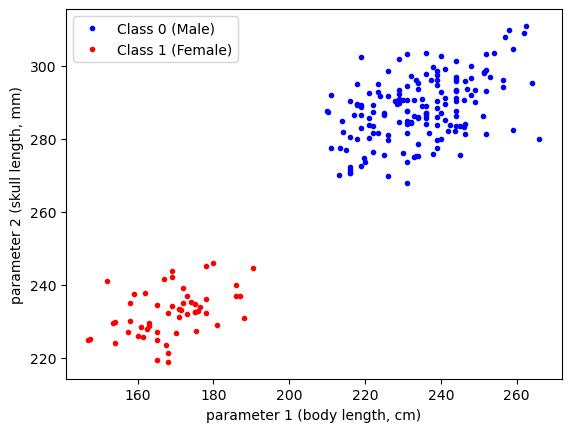

In [4]:
plt.plot(df['SL'][df['Classification']==0],
         df['CBL'][df['Classification']==0],'b.',label='Class 0 (Male)')
plt.plot(df['SL'][df['Classification']==1],
         df['CBL'][df['Classification']==1],'r.',label='Class 1 (Female)')
plt.xlabel('parameter 1 (body length, cm)')
plt.ylabel('parameter 2 (skull length, mm)')
plt.legend(loc=2)
plt.show()

Just as for our previous example, we will work with standardized variables. Let's create those for our dataset:

In [5]:
df['SL_norm'] = (df['SL'] - np.mean(df['SL']))/np.std(df["SL"])
df['CBL_norm'] = (df['CBL'] - np.mean(df['CBL']))/np.std(df["CBL"])

In addition, let's define some bounds we will use for plotting:

In [7]:
# define some bounds to be used in the plots below
min_x = -3
max_x = 3
min_y = -3
max_y = 3

## Logistic Regression

In our previous example with the perceptron, we drew a simple line to distinguish between the two classifications. However, not all solutions to this problem were ideal.

In this example, we are going to model the *probability* that a given point is associated with a given class. In symbols, we can define the probability $p$ that a given point belongs to class 1 given some input features (**x**, here, the skull and body length parameters) as 

$$
p = p(c=1 | \textbf{x} )
$$

Given this probability, we can define the *odds* as $p/(1-p)$. In logistic regression, it is assumed that the *log-odds*, also known as the *logit* function, is related to the input features in a linear way:

$$
\text{logit}(p) = \log\left(\frac{p}{1-p}\right) = b + w_1 x_1 + w_2x_2
$$

Here, the linear relation is written in terms of two input features but additional features with corresponding weights can be added as well. Since we are interested in the probability $p$, we need to apply the inverse of the *logit* function, which is termed the *sigmoid* function and has the following form:

$$
\sigma (z) = \frac{1}{1+e^{-z}}
$$

You can try this for yourself to ensure it is indeed the inverse - what happens when you plug the logit function into the sigmoid function?

Writing this explicitly, we generate a model for the probability $p$ by applying the sigmoid function to the equation above yielding:

$$
p = \frac{1}{1+e^{-(b + w_1 x_1 + w_2x_2)}}
$$

This approach is what's know as "Logistic Regression". It is important to note that the name is a little misleading - in linear regression, we fit a linear model to some data. In logistic regression, we are NOT fitting a logistic model to data. Rather, we are modeling membership in a given classes as a probability and assuming an underlying transformation for this relationship.

### Deriving gradients for logistic regression

In contrast to the previous examples where we would like to minimize a loss function, here we would like to maximize the *likelihood* function ($\mathcal{L}$) of the weights given the input features. This is given by the product of the probabilities which can be formulated with a Bernoulli distribution as follows:

$$
\mathcal{L}(\textbf{w}|\textbf{x}) = \prod_{i=1}^n p(c^{(i)}|\textbf{x}^{(i)};\textbf{w}) = \prod_{i=1}^n p^{c^{(i)}} (1- p)^{1-c^{(i)}}
$$

We *could* construct a gradient descent algorithm using this formula, but a log transform is often applied to the above equation to give the *log-likehood* function as follows:

$$
\mathcal{l}(\textbf{w}|\textbf{x}) = \sum_{i=1}^n c^{(i)} \log(p) + (1-c^{(i)})\log  (1- p)
$$

As we can see, this allows us to leverage properties of the log function to rewrite the function as a sum and remove some of the exponents - this will make the derivative computations for gradient decent much cleaner. Since the log function is a monotonically increasing function, the maximum of the log-likehood will be equivalent to the maximum of the likehood.

Keeping in line with the previous examples we've seen where we minimize a loss function, we can also multiply this function by -1 so that we can employ our typical gradient descent approach to the following loss function:

$$
L = \sum_{i=1}^n -c^{(i)} \log(p) - (1-c^{(i)})\log  (1- p)
$$

Now that we've got our function to minimize, we just need to compute our derivatives. Let's consider our bias term first. When computing the derivative of $L$, we see that $L$ is a function of $p$ which, in turn, is a function of $b$, so we must apply the chain rule:

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial p} \frac{\partial p}{\partial b}
$$

Let's compute these separately. The first derivative is:

$$
\frac{\partial L}{\partial p} = \sum_{i=1}^n \left(\frac{-c^{(i)}}{p} + \frac{1-c^{(i)}}{1-p}\right) = \sum_{i=1}^n \frac{p-c^{(i)}}{p(1-p)}
$$

and the second derivative is:

$$
\begin{align*}
\frac{\partial p}{\partial b} &= \frac{\partial }{\partial b}\left( (1+e^{-(b + w_1 x_1 + w_2x_2)})^{-1} \right)\\
&= -(1+e^{-(b + w_1 x_1 + w_2x_2)})^{-2} e^{-(b + w_1 x_1 + w_2x_2)} (-1) \\
&= \frac{1+e^{-(b + w_1 x_1 + w_2x_2)}}{(1+e^{-(b + w_1 x_1 + w_2x_2)})^2} - \frac{1}{(1+e^{-(b + w_1 x_1 + w_2x_2)})^2} \\
&= \frac{1}{1+e^{-(b + w_1 x_1 + w_2x_2)}}\left(1 - \frac{1}{1+e^{-(b + w_1 x_1 + w_2x_2)}}\right)\\
&= p(1-p)
\end{align*}
$$



Putting these together, we find that 

$$
\frac{\partial L}{\partial b} = \sum_{i=1}^n p-c^{(i)}
$$

Using similar steps, we can also compute the derivative with respect to the first weight as:

$$
\frac{\partial L}{\partial w_1} = \sum_{i=1}^n (p-c^{(i)})x_{1,i}
$$

The other weights will be identical. We can put this all together into a concise vector format as we did for our previous examples as follows:

$$
\frac{\partial L}{\partial \textbf{w}} =  (\textbf{p} - \textbf{c})^T \cdot \textbf{X}
$$

With our derivatives in hand, we're ready to start coding!

### Constructing a Logistic Regression Model

Logistic regression will follow a similar structure as our `Perceptron` and `LinearRegression` classes. To summarize the symbols above in a schematic, we can organize our steps as follows:

<img src="Logistic_Regression_Schematic.png" alt="Schematic of Logistic Regression" width="500">

Given the commonalities with the previous models, we will see some strong parallels in the code:

In [6]:
class LogisticRegression:
    def __init__(self, X, learning_rate=0.001, n_iters=1000, random_seed=1):
        """
        Parameters:
        - X: Training data matrix (num_samples x num_features)
        - learning_rate: Step size for weight updates
        - n_iters: Number of training iterations
        - random_seed: Seed for reproducibility
        """
        self.lr = learning_rate
        self.n_iters = n_iters
        self.random_seed = random_seed
        self.initialize(X)
        
    def initialize(self, X):
        """
        Initializes the weight vector with small random values.
        """
        np.random.seed(self.random_seed)
        self.w = np.random.normal(loc=0.0, scale=0.01, size=np.shape(X)[1])

    def activation(self, x):
        """Binary step activation function"""
        return np.where(x >= 0.5, 1, 0)
        
    def sigmoid(self,x):
        """Sigmoid function to map values to range 0-1"""
        sigma = 1 / (1 + np.exp(-x))
        return sigma

    def predict_probability(self, X):
        """Probability based on linear model and sigmoid transformation"""
        probability = self.sigmoid(np.dot(X, self.w))
        return probability
    
    def loss(self, p, c):
        """Log-liklihood function multiplied by -1"""
        loss = -np.sum(c * np.log(p + 1e-8) + (1 - c) * np.log(1 - p + 1e-8))
        return loss

    def fit(self, X, c):
        """Train the logistic regression model"""
        self.losses = []
        for iteration in range(self.n_iters):
            probability = self.predict_probability(X)
            gradient = np.dot(probability - c, X)
            self.w -= gradient * self.lr
            self.losses.append(self.loss(probability, c))
            
    def predict(self, X):
        """Predict binary labels for input data"""
        probability = self.predict_probability(X)
        return self.activation(probability)

Let's see how our model works in action! Let's fit it to our normalized data:

In [22]:
X = np.column_stack([np.ones_like(df['SL_norm']), df['SL_norm'], df['CBL_norm']])
model = LogisticRegression(X, n_iters = 1000)
model.fit(X, df['Classification'])

Next, let's see how our model looks:

In [23]:
# compute the model classifications
classifications_model = model.predict(X)

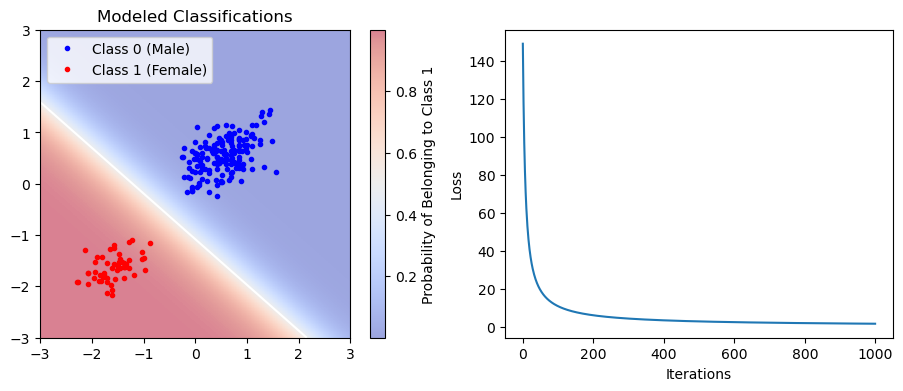

In [24]:
# make a figure
plt.figure(figsize=(11,4))

#make a figure
x1_data_span = np.linspace(min_x, max_x, 500)
x2_data_span = np.linspace(min_y, max_y, 500)
X1_data_span, X2_data_span = np.meshgrid(x1_data_span, x2_data_span)
X_2 = np.column_stack([np.ones((np.size(X1_data_span),)), X1_data_span.ravel(), X2_data_span.ravel()])
P = model.predict_probability(X_2)
P = P.reshape(np.shape(X1_data_span))

# make a plot of the data and the model probabilities
plt.subplot(1,2,1)
plt.plot(df['SL_norm'][classifications_model==0],
         df['CBL_norm'][classifications_model==0],'b.',label='Class 0 (Male)')
plt.plot(df['SL_norm'][classifications_model==1],
         df['CBL_norm'][classifications_model==1],'r.',label='Class 1 (Female)')
C = plt.pcolormesh(X1_data_span, X2_data_span, P, cmap='coolwarm', alpha=0.5)
plt.contour(X1_data_span, X2_data_span, P, levels=[0.5], colors='white')
plt.colorbar(C, label='Probability of Belonging to Class 1')
plt.gca().set_xlim([min_x,max_x])
plt.gca().set_ylim([min_y,max_y])
plt.legend(loc=2)
plt.title('Modeled Classifications')

# make a plot of the losses
plt.subplot(1,2,2)
plt.plot(model.losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')

plt.show()

## Using the Trained Logistic Regression Model

Ok, now that we've got our trained model, how do we use it? Well, we could imagine an independent measurement of a sea lion from our underwater photography as follows:

In [30]:
body_length = 240 #cm
skull_length = 260 #mm

To use this in our model, we need to first apply the standardization transformation:

In [31]:
body_length_norm = (body_length - np.mean(df['SL'])) / np.std(df['SL'])
skull_length_norm = (skull_length - np.mean(df['CBL'])) / np.std(df['CBL'])

Then, we pass these into the predict method using the expected vector format:

In [33]:
classification = model.predict([1, body_length_norm, skull_length_norm])
if classification == 0:
    print('Male')
else:
    print('Female')

Male


Note that this only gives us the classification - but using our model, we can also assign a probability to this classification. Let's compute that here:

In [35]:
probability = model.predict_probability([1, body_length_norm, skull_length_norm])

Recall how we formulated our probability above - this is the probability that the sample belongs to class 1. In other words, it is the probability that the sea lion is female:

In [36]:
print(probability)

0.029332142404638856


**Key Takeaways**

1. Logistic regression assumes a linear relationship between the input features and the log-odds of a sample belonging to a given class
2. The model assigns not only a classification to a give class, but also a probability.
3. Despite the unique formulation of the problem, the structure of the class is very similar to the linear regression and 